In [24]:
import optuna
import pandas as pd
import torch
import os
import re
import scipy.io as sio
from glob import glob
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Detect base directory robustly
try:
    base_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
except NameError:
    base_dir = os.path.dirname(os.path.abspath(os.getcwd()))


def load_one(file_path, V_rms):
    if not os.path.exists(file_path):
        raise FileNotFoundError(file_path)

    # --- extract metadata from filename ---
    fname = os.path.basename(file_path)
    # Example: sweep_50_500K_9000_1v_t10920_25.8.mat
    m = re.match(r"sweep_(\d+)_([\d\.]+)K_\d+_([\d\.]+)v_t(\d+)_([\d\.]+)\.mat", fname)
    if not m:
        raise ValueError(f"Unexpected filename format: {fname}")
    start_freq = float(m.group(1))
    stop_freq = float(m.group(2)) * 1e3  # convert K→Hz
    stim_voltage = float(m.group(3))
    weight = float(m.group(4)) / 100      # 10920 → 109.20 g
    temperature = float(m.group(5))


    # --- load .mat ---
    S = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    fn = [k for k in S.keys() if not k.startswith("__")]
    dev = getattr(S[fn[0]], "demods", None)
    if dev is None or not hasattr(dev, "sample"):
        raise KeyError(f"No dev.demods.sample in {file_path}")

    s = dev.sample
    if isinstance(s, (list, np.ndarray)) and len(s) > 0:
        s = s[0]

    f = np.array(s.frequency, dtype=float)
    X = np.array(s.x, dtype=float)
    Y = np.array(s.y, dtype=float)

    # Complex current and impedance
    I = X + 1j * Y
    I_mag = np.abs(I)
    epsI = max(np.max(I_mag) * 1e-12, 1e-18)
    I[I_mag < epsI] = epsI

    Z = V_rms / I
    R = np.real(Z)
    Xc = np.imag(Z)
    Zmag = np.abs(Z)
    Zphase = np.degrees(np.angle(Z))

    return {
        "file": file_path,
        "f": f,
        "R": R,
        "Xc": Xc,
        "Zmag": Zmag,
        "Zphase": Zphase,
        "weight_g": weight,
        "temperature_C": temperature,
        "V_rms": V_rms,
        "start_freq": start_freq,
        "stop_freq": stop_freq,
        "stim_voltage": stim_voltage,
    }

data_dir = "Datafolder"
full_data_dir = os.path.join(base_dir, data_dir)

files = glob(os.path.join(full_data_dir, "*.mat"))

datasets = [
    load_one(f, V_rms=1.0)
    for f in files
]

# Organize datasets by weight, starting with the highest weight
datasets = sorted(datasets, key=lambda x: x["weight_g"], reverse=True)

Found 8 unique samples: ['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8']
Found 51 timestamped directories
Processing 2025-09-30_18-00-03 (1/51)
Processing 2025-10-01_06-00-03 (2/51)
Processing 2025-10-01_12-27-23 (3/51)
Processing 2025-10-01_18-00-03 (4/51)
Processing 2025-10-01_12-27-23 (3/51)
Processing 2025-10-01_18-00-03 (4/51)
Processing 2025-10-02_06-00-03 (5/51)
Processing 2025-10-02_18-00-03 (6/51)
Processing 2025-10-03_06-00-02 (7/51)
Processing 2025-10-02_06-00-03 (5/51)
Processing 2025-10-02_18-00-03 (6/51)
Processing 2025-10-03_06-00-02 (7/51)
Processing 2025-10-03_18-00-02 (8/51)
Processing 2025-10-04_06-00-03 (9/51)
Processing 2025-10-03_18-00-02 (8/51)
Processing 2025-10-04_06-00-03 (9/51)
Processing 2025-10-04_18-00-03 (10/51)
Processing 2025-10-05_06-00-04 (11/51)
Processing 2025-10-04_18-00-03 (10/51)
Processing 2025-10-05_06-00-04 (11/51)
Processing 2025-10-05_18-00-02 (12/51)
Processing 2025-10-06_06-00-03 (13/51)
Proc

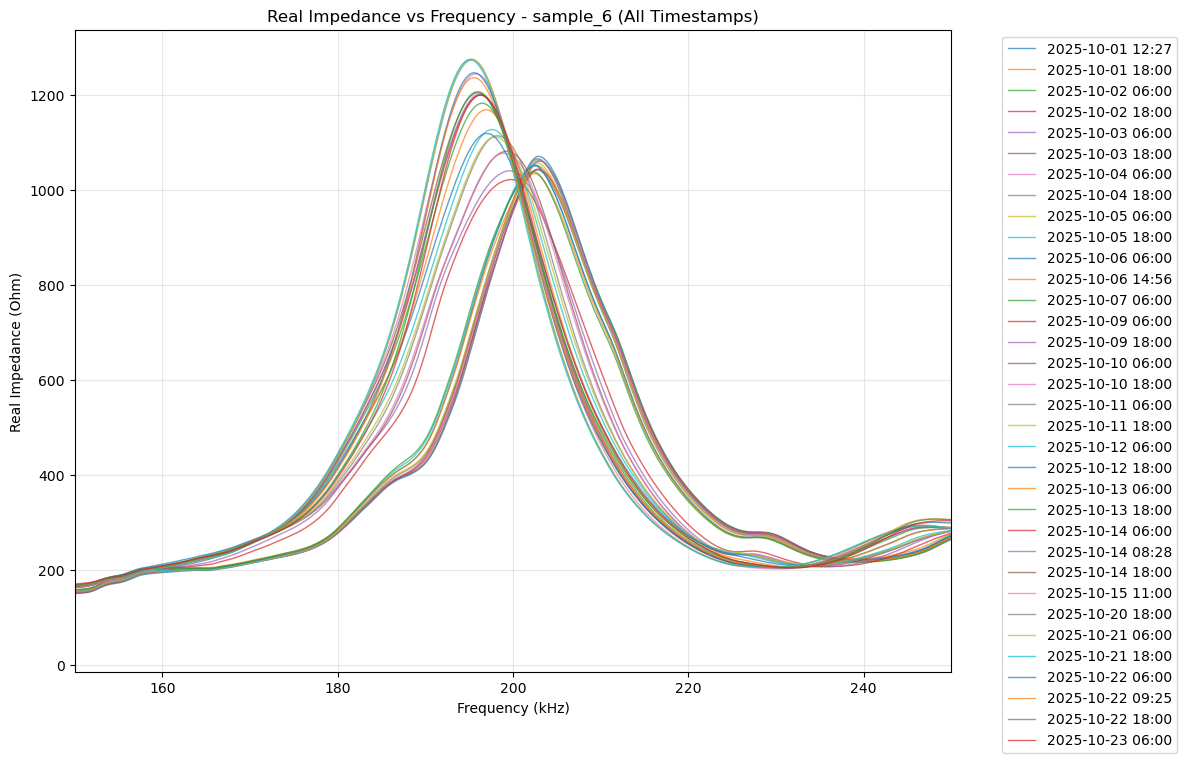

Plotted 34 measurements for sample_6


In [25]:
# Add parent directory to Python path so we can import from src
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Import the loading function
from src.Load_Accelerated_corrosion_test_data import load_accelerated_corrosion_data

# Load the data
data = load_accelerated_corrosion_data()

# Access the components
frequencies = data['frequency']          # Array of 9000 frequency points (50-500 kHz)
real_impedance = data['real_data']       # DataFrame: timestamps × samples
imag_impedance = data['imag_data']       # DataFrame: timestamps × samples  
timestamps = data['timestamps']          # DatetimeIndex of measurement times
sample_names = data['sample_names']      # List of available samples

# Plot all real impedance data from sample_6
plt.figure(figsize=(12, 8))

sample_to_plot = "sample_6"

if sample_to_plot in real_impedance.columns:
    # Get all non-null measurements for sample_6
    sample_data = real_impedance[sample_to_plot].dropna()
    
    # Plot each timestamp's data
    for timestamp, impedance_array in sample_data.items():
        plt.plot(frequencies / 1000, impedance_array, 
                alpha=0.7, linewidth=1, 
                label=f'{timestamp.strftime("%Y-%m-%d %H:%M")}')
    
    plt.xlim(150, 250)
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Real Impedance (Ohm)")
    plt.title(f"Real Impedance vs Frequency - {sample_to_plot} (All Timestamps)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted {len(sample_data)} measurements for {sample_to_plot}")
else:
    print(f"{sample_to_plot} not found in available samples: {sample_names}")

In [26]:
# Test minimal version - restart kernel first
print("Testing imports...")
import importlib
import data_prep
importlib.reload(data_prep)

from data_prep import prepare_training_data, prepare_evaluation_data
print("Imports successful!")

# Test training data only first
print("Testing training data...")
training_result = prepare_training_data(datasets, freq_start_khz=165, freq_stop_khz=200)
print(f"Training data shape: {training_result['X_data'].shape}")
print("Training successful!")

Testing imports...
Imports successful!
Testing training data...
Training data shape: (29, 2100)
Training successful!


In [27]:
# Final working example with the cleaned data_prep functions
from data_prep import prepare_training_data, prepare_evaluation_data
import pandas as pd

print("=== COMPLETE DATA PREPARATION EXAMPLE ===")

# 1. Prepare training data
print("\n1. Training Data:")
training_result = prepare_training_data(
    datasets=datasets,
    freq_start_khz=165,
    freq_stop_khz=200
)

X_train = training_result['X_data']
y_train = training_result['y_data']
scaler = training_result['scaler']
reference_data = training_result['reference_data']

print(f"   - Training data shape: {X_train.shape}")
print(f"   - Training labels shape: {y_train.shape}")

# 2. Prepare evaluation data
print("\n2. Evaluation Data:")
start_date = pd.Timestamp('2025-10-15')
end_date = pd.Timestamp('2025-10-22 23:59:59')

evaluation_result = prepare_evaluation_data(
    real_impedance=real_impedance,
    imag_impedance=imag_impedance,
    frequencies=frequencies,
    sample_name="sample_6",
    scaler=scaler,                    # Reuse from training
    reference_data=reference_data,    # Reuse from training
    freq_start_khz=165,
    freq_stop_khz=200,
    freq_offset=20,                   # 20 kHz offset for evaluation
    date_range=(start_date, end_date)
)

X_eval = evaluation_result['X_data']
timestamps = evaluation_result['timestamps']

print(f"   - Evaluation data shape: {X_eval.shape}")
print(f"   - Number of timestamps: {len(timestamps)}")
print(f"   - Date range: {timestamps[0]} to {timestamps[-1]}")

print("\n✅ Data preparation complete!")
print(f"✅ Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"✅ Evaluation: {X_eval.shape[0]} samples, {X_eval.shape[1]} features")
print(f"✅ Both datasets use consistent preprocessing pipeline")

=== COMPLETE DATA PREPARATION EXAMPLE ===

1. Training Data:
   - Training data shape: (29, 2100)
   - Training labels shape: (29, 1)

2. Evaluation Data:
   - Evaluation data shape: (7, 2100)
   - Number of timestamps: 7
   - Date range: 2025-10-15 11:00:19 to 2025-10-22 18:00:04

✅ Data preparation complete!
✅ Training: 29 samples, 2100 features
✅ Evaluation: 7 samples, 2100 features
✅ Both datasets use consistent preprocessing pipeline
